In [1]:
import numpy as np
import matplotlib.pyplot as plt

import sys
from pathlib import Path
sys.path.insert(0, str(Path().resolve().parents[1]))
from model import left_right_task as lrt, network_model, plot_style, util

In [2]:
areas = np.load('trace_vs_det/areas.npy', allow_pickle=True)
WEE_mesh = np.load('trace_vs_det/WEE_mesh.npy', allow_pickle=True)
WEI_mesh = np.load('trace_vs_det/WEI_mesh.npy', allow_pickle=True)
WIE_mesh = np.load('trace_vs_det/WIE_mesh.npy', allow_pickle=True)
WII_mesh = np.load('trace_vs_det/WII_mesh.npy', allow_pickle=True)

In [3]:
n = 30
traces = np.logspace(0, 5, n) * -1
determinants = np.logspace(5, 7, n)
trace_mesh, determinant_mesh = np.meshgrid(traces, determinants)

WEE_mesh = WEE_mesh.reshape((n, n))
WEI_mesh = WEI_mesh.reshape((n, n))
WIE_mesh = WIE_mesh.reshape((n, n))
WII_mesh = WII_mesh.reshape((n, n))

In [4]:
m = 50
stimulus_durations = np.logspace(-3, 0, m)
stimulus_amplitudes = np.logspace(0, 2, m)
STIM_DUR, STIM_AMP = np.meshgrid(stimulus_durations, stimulus_amplitudes)
STIM_DUR_, STIM_AMP_ = STIM_DUR.ravel(), STIM_AMP.ravel()

In [5]:
n_stimuli = m ** 2
norm_areas = areas / n_stimuli
Lx = np.max(stimulus_durations)/np.min(stimulus_durations)
Ly = np.max(stimulus_amplitudes)/np.min(stimulus_amplitudes)
fold_areas = norm_areas.reshape((n, n)) * (Lx * Ly) # Area in fold-fold change space
radii = np.sqrt(fold_areas / np.pi) # radius expresses the fold change in terms of a circle's radius

In [8]:
selected_points = [(1, 3), (6, 8),(5, 20)]

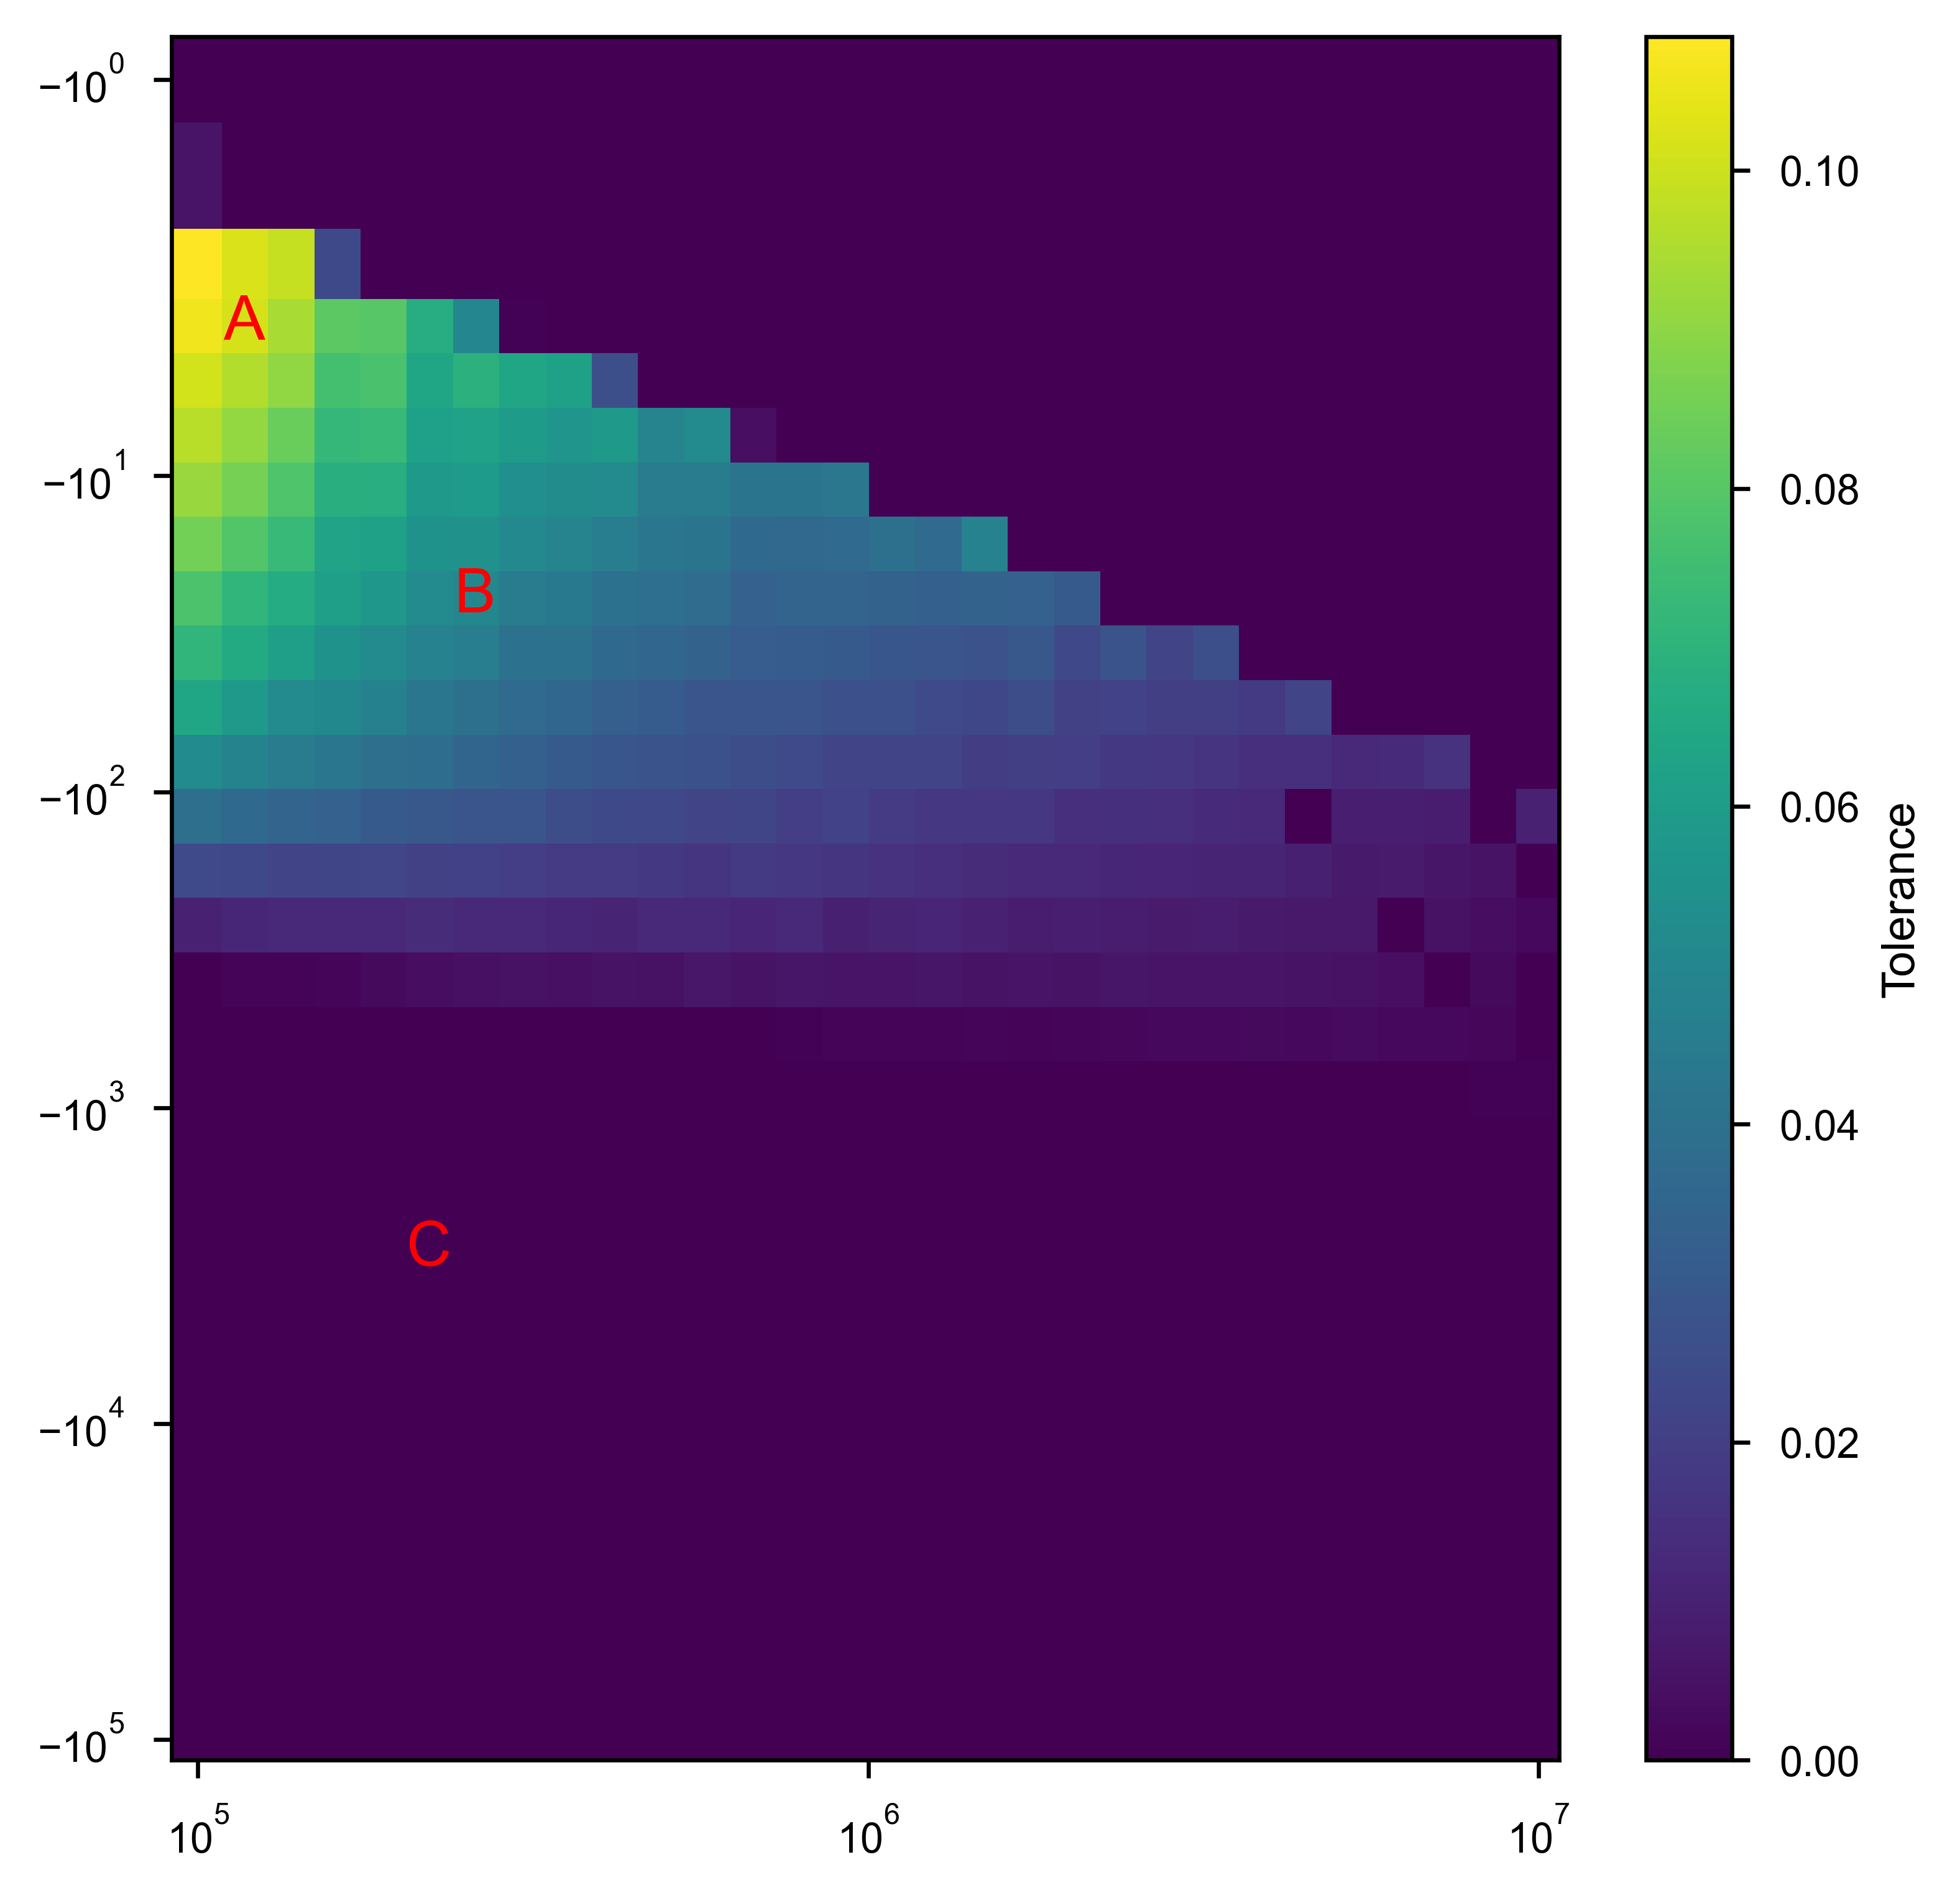

In [9]:
fig, ax = plt.subplots(figsize=(6,6))
c = ax.pcolormesh(determinant_mesh, trace_mesh, norm_areas.reshape(trace_mesh.shape), shading='auto', cmap='viridis')
for i, point in enumerate(selected_points):
    x, y = point
    ax.text(determinants[x], traces[y], chr(65 + i), color='red', fontsize=12, ha='center', va='center')
ax.set_xscale('symlog')
ax.set_yscale('symlog')
fig.colorbar(c, ax=ax, label='Tolerance')
plt.show()

In [40]:
# core parameters
rE_target = 10
rI_target = 5
thetaE = 5.34
thetaI = 82.43

max_duration = 12
dt = 1e-5

# simulation wrapper function
def bistable_no_depression(stimulus_duration, stimulus_amplitude, 
                           dt, max_duration:int,
                           WEE, WEI, WIE, WII, thetaE, thetaI, tauE=10e-3, tauI=10e-3,
                           initial_conditions=[0, 0]):
    duration = max_duration
    rmax = 100
    total_duration = duration + stimulus_duration + 1 # 1 second of equilibration pre-stimulus
    
    IappI = np.zeros(int(total_duration/dt))
    IappE = np.zeros(int(total_duration/dt))
    IappE[int(1/dt):int((stimulus_duration + 1)/dt)] = stimulus_amplitude
    IappI[int(1/dt):int((stimulus_duration + 1)/dt)] = stimulus_amplitude

    rE, rI = network_model.simulateISP(dt, total_duration, rmax, tauE, tauI, 
                            WEE, WEI, WIE, WII, thetaE, thetaI,
                            IappI, IappE, rE0=initial_conditions[0], rI0=initial_conditions[1])   
    # check stability
    stable = np.allclose(rE[int((max_duration - 0.1)/dt):], rE[-1], atol=0.1, rtol=0)
    
    if not stable: # flag as unstable with negative values
        rE *= -1
        rI *= -1
    return rE, rI

def trial(stim_amp, stim_dur, WEE, WEI, WIE, WII):
    rE, rI = bistable_no_depression(stim_dur, stim_amp, 
                                            dt, max_duration,
                                            WEE, WEI, WIE, WII, thetaE, thetaI)
    if np.any(rE < 0) or rE[-1] == 100 or rI[-1] == 100: # if not stable, go to next stimulus
        return 0
    on = (int((rE[-1] > 0.1) and (rI[-1] > 0.1))) # check if ON
    # run again
    if on:
        rE, rI = bistable_no_depression(stim_dur, stim_amp, 
                                        dt, max_duration,
                                        WEE, WEI, WIE, WII, thetaE, thetaI, 
                                        initial_conditions=[rE[-1], rI[-1]])
        if np.any(rE < 0): # if not stable, go to next stimulus
            return 0
        on = (int((rE[-1] > 0.1) and (rI[-1] > 0.1))) # check if ON
        if not on:
            return 1
    return 0

In [50]:
sample_responses = np.zeros((len(selected_points), len(STIM_AMP_), len(STIM_DUR_)))
for i, (x, y) in enumerate(selected_points):
    WEE = WEE_mesh[x, y]
    WEI = WEI_mesh[x, y]
    WIE = WIE_mesh[x, y]
    WII = WII_mesh[x, y]
    
    for j, stim_amp in enumerate(STIM_AMP_):
        for k, stim_dur in enumerate(STIM_DUR_):
            sample_responses[i, j, k] = trial(stim_amp, stim_dur, WEE, WEI, WIE, WII)
    total = np.sum(sample_responses[i])
    print(f"Area for point {chr(65 + i)}: {total} out of {len(STIM_AMP_) * len(STIM_DUR_)} -- {total / (len(STIM_AMP_) * len(STIM_DUR_)):.2%}")

KeyboardInterrupt: 